In [1]:
# General Utilities
import os
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Model & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Define paths
data_dir = r'E:\file_main\Minor_1\file_dataset'
input_file = os.path.join(data_dir, 'fifa23_official_data.csv')
output_file = os.path.join(data_dir, 'fifa23_official_data_preprocessed.csv')


In [3]:
chunk_size = 1000
header_saved = False

num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()

def convert_currency(value):
    if isinstance(value, str):
        value = ''.join(filter(lambda x: x.isdigit() or x in ['M', 'K', '.', ' '], value)).strip()
        if value.endswith('M'):
            return float(value[:-1]) * 1_000_000
        elif value.endswith('K'):
            return float(value[:-1]) * 1_000
        else:
            try:
                return float(value)
            except ValueError:
                return 0.0
    return 0.0

def convert_height_weight(value):
    return int(value.replace('cm', '').strip()) if isinstance(value, str) else 0

# Process in chunks
for chunk in pd.read_csv(input_file, chunksize=chunk_size):
    chunk = chunk.dropna(axis=1, how='all')

    excluded_cols = ['ID', 'Age', 'Kit Number', 'Special']
    num_cols = chunk.select_dtypes(include=['float64', 'int64']).columns.difference(excluded_cols)
    cat_cols = chunk.select_dtypes(include=['object']).columns.difference(excluded_cols)

    chunk[num_cols] = num_imputer.fit_transform(chunk[num_cols])
    chunk[cat_cols] = cat_imputer.fit_transform(chunk[cat_cols])

    for col in ['Value', 'Wage', 'Release Clause']:
        if col in chunk.columns:
            chunk[col] = chunk[col].apply(convert_currency)

    if 'Height' in chunk.columns:
        chunk['Height'] = chunk['Height'].apply(convert_height_weight)
    if 'Weight' in chunk.columns:
        chunk['Weight'] = chunk['Weight'].apply(lambda x: int(x.replace('kg', '').strip()) if isinstance(x, str) else 0)

    if 'Preferred Foot' in chunk.columns:
        chunk['Preferred Foot'] = chunk['Preferred Foot'].map({'Right': 1, 'Left': 0}).fillna(0).astype(int)

    if 'Position' in chunk.columns:
        position_map = {
            'SUB': 0, 'LCM': 1, 'LB': 2, 'RCM': 3, 'RDM': 4, 'LCB': 5, 'RB': 6,
            'LM': 7, 'RS': 8, 'ST': 9, 'GK': 10, 'RW': 11, 'CF': 12, 'LW': 13,
            'CAM': 14, 'CDM': 15, 'CB': 16, 'RWB': 17, 'LWB': 18, 'RAM': 19, 'LAM': 20
        }
        chunk['Position'] = chunk['Position'].str.extract(r'>(\w+)', expand=False).map(position_map).fillna(99).astype(int)

    if 'Work Rate' in chunk.columns:
        work_rate_map = {
            'High/ High': 3, 'High/ Medium': 2.5, 'Medium/ High': 2.5,
            'Medium/ Medium': 2, 'High/ Low': 2, 'Low/ High': 2,
            'Medium/ Low': 1.5, 'Low/ Medium': 1.5, 'Low/ Low': 1
        }
        chunk['Work Rate Encoded'] = chunk['Work Rate'].map(work_rate_map).fillna(2).astype(float)

    chunk[num_cols] = scaler.fit_transform(chunk[num_cols])
    chunk.to_csv(output_file, mode='a', index=False, header=not header_saved)
    header_saved = True

print("Preprocessing complete. Saved to:", output_file)


Preprocessing complete. Saved to: E:\file_main\Minor_1\file_dataset\fifa23_official_data_preprocessed.csv


C:\Users\Dell\AppData\Local\Temp\ipykernel_11600\2485606802.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_corr.index, y=value_corr['Value'], palette='coolwarm')


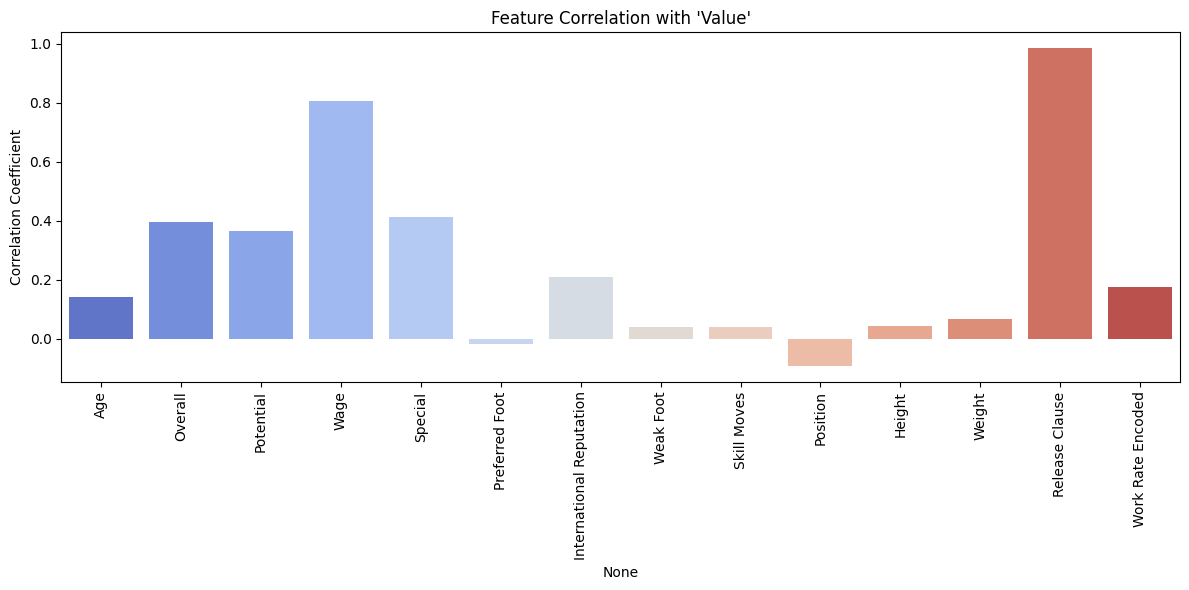

                             Value
Release Clause            0.985096
Wage                      0.805169
Special                   0.413166
Overall                   0.394962
Potential                 0.365610
International Reputation  0.210941
Work Rate Encoded         0.174788
Age                       0.142080
Weight                    0.066839
Height                    0.042242
Skill Moves               0.038967
Weak Foot                 0.038774
Preferred Foot           -0.018166
Position                 -0.091909


In [4]:
df = pd.read_csv(output_file, on_bad_lines='skip')
df_numeric = df.select_dtypes(include=['float64', 'int64']).drop(columns=['ID', 'Kit Number'], errors='ignore')

correlation_matrix = df_numeric.corr()
value_corr = correlation_matrix[['Value']].drop('Value')

plt.figure(figsize=(12, 6))
sns.barplot(x=value_corr.index, y=value_corr['Value'], palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Feature Correlation with 'Value'")
plt.ylabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

print(value_corr.sort_values(by='Value', ascending=False))


In [5]:
vif_data = df_numeric.drop(columns=['Value'], errors='ignore')
scaled_data = pd.DataFrame(scaler.fit_transform(vif_data), columns=vif_data.columns)

vif_df = pd.DataFrame()
vif_df["Feature"] = scaled_data.columns
vif_df["VIF"] = [variance_inflation_factor(scaled_data.values, i) for i in range(scaled_data.shape[1])]

print("Variance Inflation Factors:\n", vif_df)

Variance Inflation Factors:
                      Feature       VIF
0                        Age  4.005580
1                    Overall  3.093352
2                  Potential  3.774484
3                       Wage  3.079686
4                    Special  2.531939
5             Preferred Foot  1.038043
6   International Reputation  1.379101
7                  Weak Foot  1.055061
8                Skill Moves  1.094718
9                   Position  1.094379
10                    Height  2.567800
11                    Weight  2.491303
12            Release Clause  2.970812
13         Work Rate Encoded  1.138210


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Exclude non-numeric or irrelevant columns
irrelevant_columns = ['Name', 'Nationality', 'Club', 'Work Rate', 'Position', 'Preferred Foot', 
                      'Joined', 'Loaned From', 'Contract Valid Until']

# Keep only numeric columns, drop the target 'Value' later
numerical_columns = [col for col in df.columns if col not in irrelevant_columns and df[col].dtype in ['float64', 'int64']]

# Features and target
X = df[numerical_columns].drop('Value', axis=1, errors='ignore')
y = df['Value']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("Random Forest")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))
print("R2 Score:", r2_score(y_test, y_pred_rf))


Random Forest
MAE: 386075.87242026266
RMSE: 1095257.968564585
R2 Score: 0.9872801185529455


D:\Python\3.11\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [8]:
from sklearn.tree import DecisionTreeRegressor

model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)

print("\nDecision Tree")
print("MAE:", mean_absolute_error(y_test, y_pred_dt))
print("RMSE:", mean_squared_error(y_test, y_pred_dt, squared=False))
print("R2 Score:", r2_score(y_test, y_pred_dt))


Decision Tree
MAE: 495358.81801125704
RMSE: 1439468.6576707775
R2 Score: 0.9780287560167804


D:\Python\3.11\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Scale features for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_svr = SVR(kernel='rbf')
model_svr.fit(X_train_scaled, y_train)
y_pred_svr = model_svr.predict(X_test_scaled)

print("\nSupport Vector Regression (SVR)")
print("MAE:", mean_absolute_error(y_test, y_pred_svr))
print("RMSE:", mean_squared_error(y_test, y_pred_svr, squared=False))
print("R2 Score:", r2_score(y_test, y_pred_svr))



Support Vector Regression (SVR)
MAE: 3637788.283846506
RMSE: 10170186.787420891
R2 Score: -0.09675110105420881


D:\Python\3.11\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

print("\nXGBoost")
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", mean_squared_error(y_test, y_pred_xgb, squared=False))
print("R2 Score:", r2_score(y_test, y_pred_xgb))



XGBoost
MAE: 379059.5501723871
RMSE: 1206942.5682091268
R2 Score: 0.9845537368217289


D:\Python\3.11\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


D:\Python\3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting SHAP analysis...

Analyzing: Random Forest


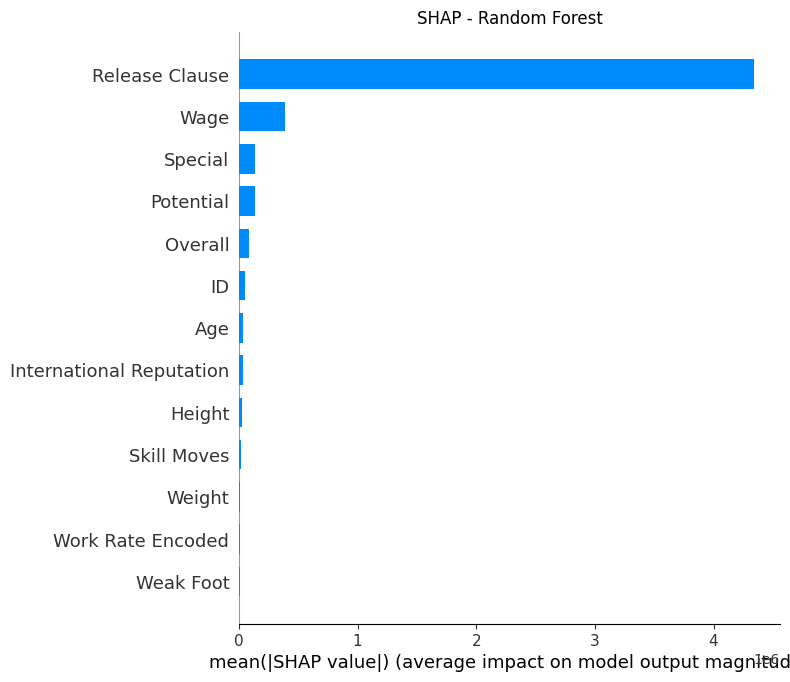

Done in 242.14 seconds

Analyzing: Decision Tree


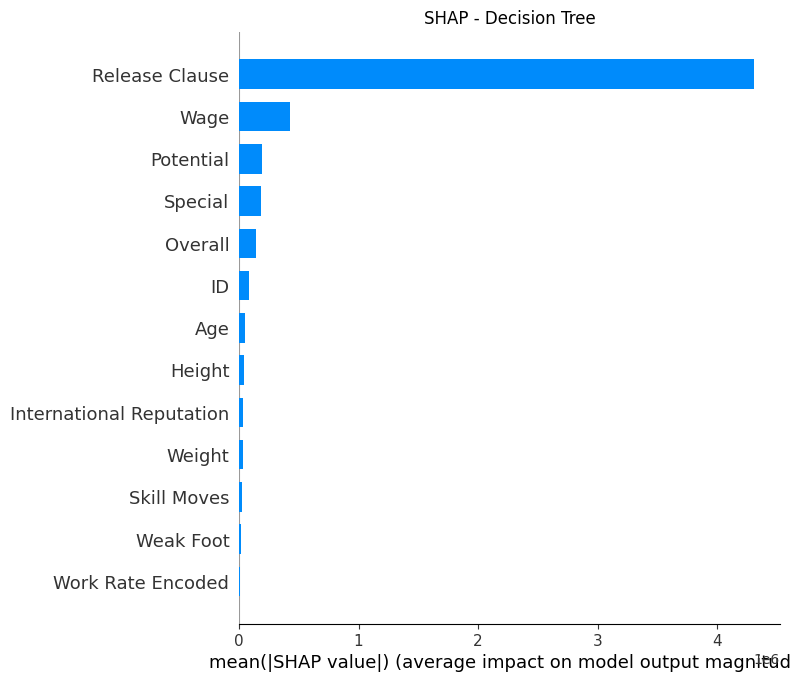

Done in 3.54 seconds

Analyzing: XGBoost


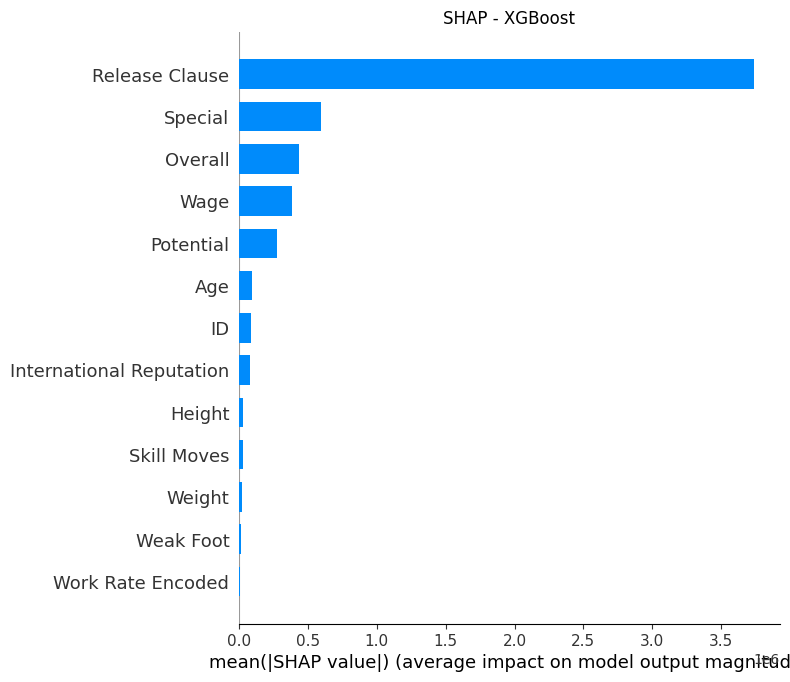

Done in 0.75 seconds

All SHAP analyses complete.


In [12]:
import shap
import matplotlib.pyplot as plt
import time

print("Starting SHAP analysis...\n")

# Random Forest
print("Analyzing: Random Forest")
start = time.time()
explainer_rf = shap.TreeExplainer(model_rf)
shap_values_rf = explainer_rf.shap_values(X_test)
shap.summary_plot(shap_values_rf, X_test, plot_type="bar", show=False)
plt.title("SHAP - Random Forest")
plt.show()
print(f"Done in {time.time() - start:.2f} seconds\n")

# Decision Tree
print("Analyzing: Decision Tree")
start = time.time()
explainer_dt = shap.TreeExplainer(model_dt)
shap_values_dt = explainer_dt.shap_values(X_test)
shap.summary_plot(shap_values_dt, X_test, plot_type="bar", show=False)
plt.title("SHAP - Decision Tree")
plt.show()
print(f"Done in {time.time() - start:.2f} seconds\n")

# XGBoost
print("Analyzing: XGBoost")
start = time.time()
explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", show=False)
plt.title("SHAP - XGBoost")
plt.show()
print(f"Done in {time.time() - start:.2f} seconds\n")

print("All SHAP analyses complete.")


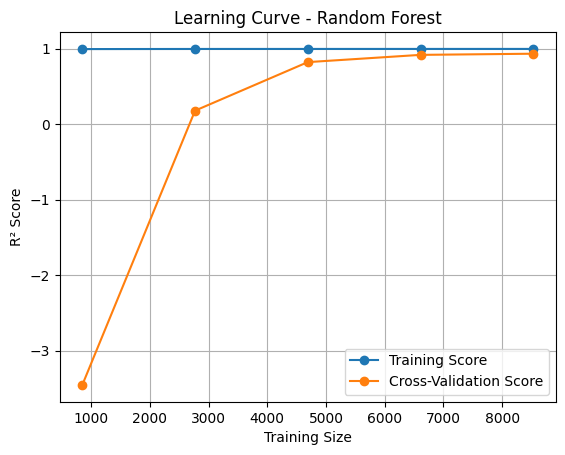

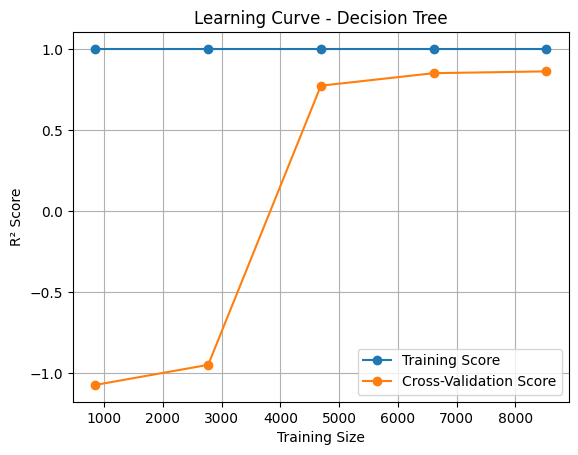

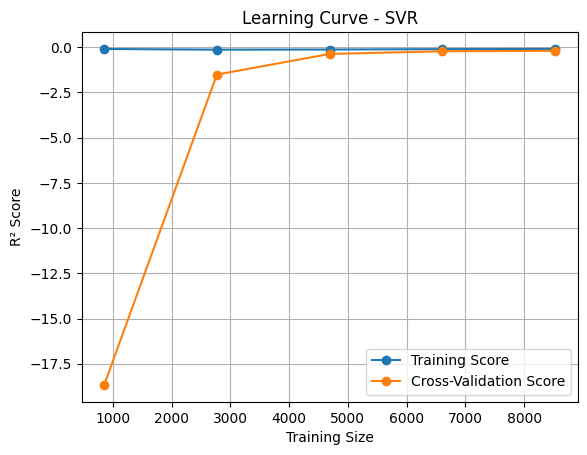

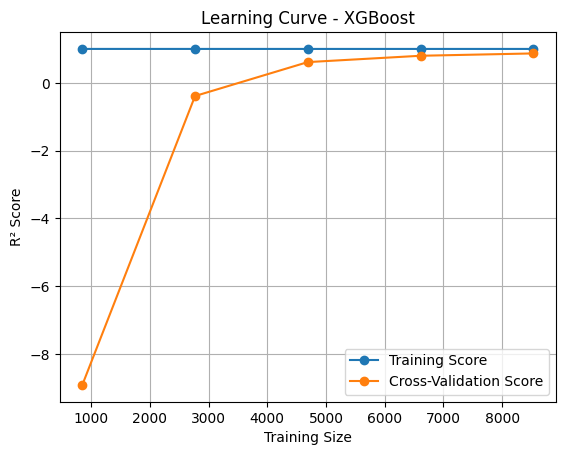

In [11]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(model, title, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.plot(train_sizes, train_mean, 'o-', label="Training Score")
    plt.plot(train_sizes, val_mean, 'o-', label="Cross-Validation Score")
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("R² Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot learning curves
plot_learning_curve(model_rf, "Learning Curve - Random Forest", X, y)
plot_learning_curve(model_dt, "Learning Curve - Decision Tree", X, y)
plot_learning_curve(model_svr, "Learning Curve - SVR", X, y)
plot_learning_curve(model_xgb, "Learning Curve - XGBoost", X, y)
